In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping, ModelCheckpoint

import joblib

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

%matplotlib inline

## Import Data

In [3]:
train_path, test_path = '../data/processed/train_Bearing_Nasa.csv', '../data/processed/test_Bearing_Nasa.csv'
train, test = pd.read_csv(train_path), pd.read_csv(test_path) 

train = train.set_index('Date_parsed')
test = test.set_index('Date_parsed')

### Scaling

In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
scaler_filename = "../models/scaler_data.pkl"
joblib.dump(scaler, scaler_filename)

['../models/scaler_data.pkl']

## Modeling

### RandomizedSearch Autoencoder

In [6]:
# Build the autoencoder model
def create_autoencoder(input_dim, num_hidden_layers, hidden_layer_sizes, dropout_rate, learning_rate):
    inputs = Input(shape=(input_dim,))
    encoded = inputs
    
    for layer_size in range(num_hidden_layers):
        encoded = Dense(int((hidden_layer_sizes/(layer_size+1))), activation="selu", kernel_initializer="lecun_normal")(encoded)    # selu + lecun = avoid exploding gradient
        encoded = Dropout(rate=dropout_rate)(encoded)
    decoded = encoded

    for layer_size in range(num_hidden_layers):
        decoded = Dense(int((hidden_layer_sizes/(layer_size+1))), activation="selu", kernel_initializer="lecun_normal")(decoded)
        encoded = Dropout(rate=dropout_rate)(encoded)
    decoded = Dense(input_dim, activation='relu')(decoded)

    autoencoder = Model(inputs, decoded)
    optimizer = Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
    #autoencoder.summary()
    return autoencoder

#input_dim = 

# Define the search space and search for the best hyperparameters using RandomizedSearchCV
params = {
    'input_dim': [4, None],
    'num_hidden_layers': range(1, 5),
    'hidden_layer_sizes': [8, 16, 32, 64],
    'learning_rate': [10 ** i for i in range(-4, -1)],
    'dropout_rate': [0, 0.1, 0.2, 0.4]
}

autoencoder_model = KerasRegressor(build_fn=create_autoencoder)

# create the randomized search object
autoencoder_search = RandomizedSearchCV(estimator=autoencoder_model,
                                        param_distributions=params,
                                        cv=5,
                                        random_state=42,
                                        n_jobs=3)

early_stopping = EarlyStopping(monitor="val_loss", patience=8, mode="min")
checkpoint = ModelCheckpoint(filepath='../models/autoencoder.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

try:
    os.remove("../models/autoencoder.h5")
except:
    print("No model saved yet")

# fit the randomized search object to the training data
autoencoder_search.fit(train_scaled,train_scaled,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    shuffle=True,
                    callbacks=[early_stopping, checkpoint],
                    verbose=0)

print(autoencoder_search.best_params_)

5/5 [==============================] - 0s 2ms/step - loss: 0.1990


2023-01-30 10:33:58.249512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-30 10:33:58.249552: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-30 10:33:58.249583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mathysg-manjaro): /proc/driver/nvidia/version does not exist
2023-01-30 10:33:58.250019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'num_hidden_layers': 1, 'learning_rate': 0.001, 'input_dim': 4, 'hidden_layer_sizes': 64, 'dropout_rate': 0.2}


#### Training Result

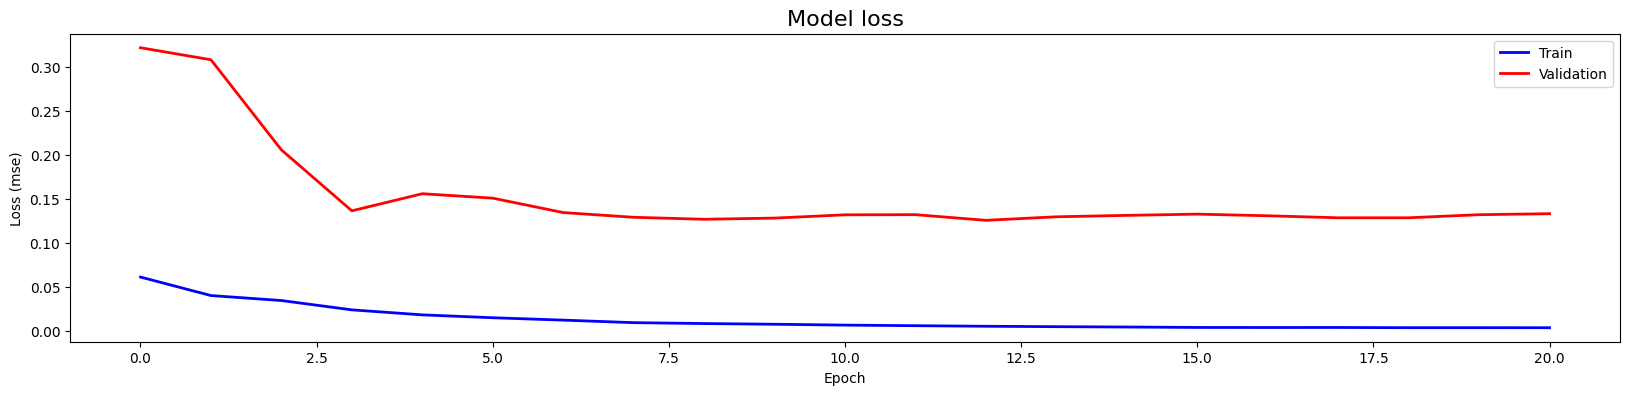

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(autoencoder_search.best_estimator_.model.history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(autoencoder_search.best_estimator_.model.history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
reconstructions = autoencoder_search.predict(train_scaled)
train_mae_loss = np.mean(np.abs(reconstructions - train_scaled), axis=1)

#threshold = np.max(train_mae_loss)
threshold = np.mean(train_mae_loss) + 2*np.std(train_mae_loss)
print("Global Reconstruction error threshold: ", threshold)

23/23 [==============================] - 0s 1ms/step
Global Reconstruction error threshold:  0.1906113755488866


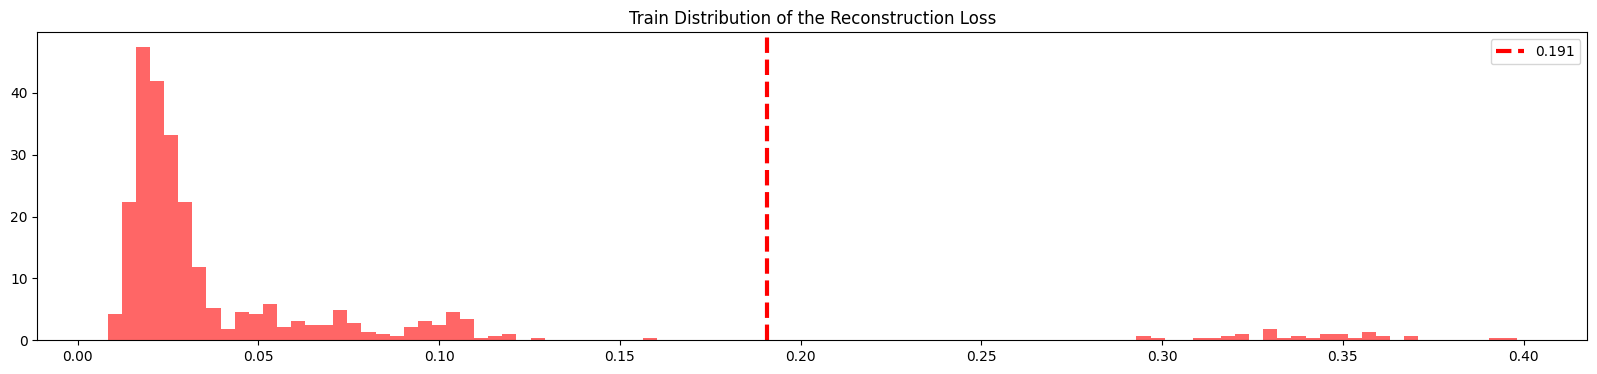

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

ax.hist(train_mae_loss, bins=100, density=True, alpha=.6, color="red")
plt.axvline(threshold, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Train Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

#### Testing Result

In [ ]:
reconstructions = autoencoder_search.predict(test_scaled)
test_mae_loss = np.mean(np.abs(reconstructions - test_scaled), axis=1)

8/8 [==============================] - 0s 1ms/step


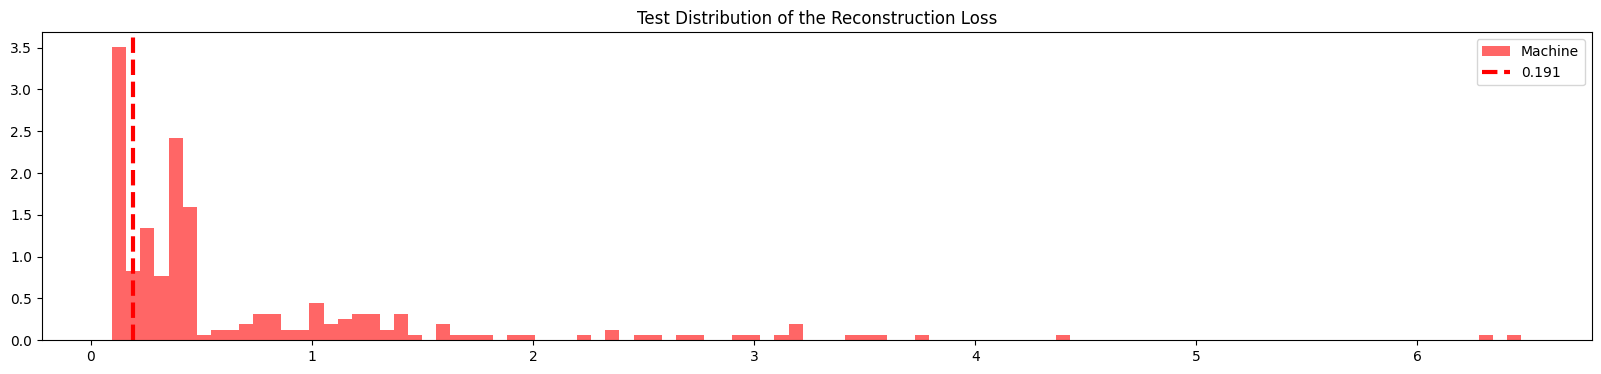

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

ax.hist(test_mae_loss, bins=100, density=True, label="Machine", alpha=.6, color="red")
plt.axvline(threshold, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Test Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

### Anomalies Visualization

In [ ]:
test['Loss'] = test_mae_loss
test.loc[test['Loss'] <= threshold, 'Anomaly'] = "Normal"
test.loc[test['Loss'] >= threshold, 'Anomaly'] = "Anomaly"
test['Threshold'] = threshold

test.to_csv('../data/final/test_Bearing_Nasa_AD.csv')
test.head(3)

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Loss,Anomaly,Threshold
Date_parsed,,,,,,,
2004-02-17 13:32:39,0.103776,0.076850,0.078618,0.050461,0.264208,Anomaly,0.190611
2004-02-17 13:42:39,0.101590,0.075820,0.077957,0.050430,0.248154,Anomaly,0.190611
2004-02-17 13:52:39,0.106605,0.077271,0.079289,0.051178,0.295600,Anomaly,0.190611


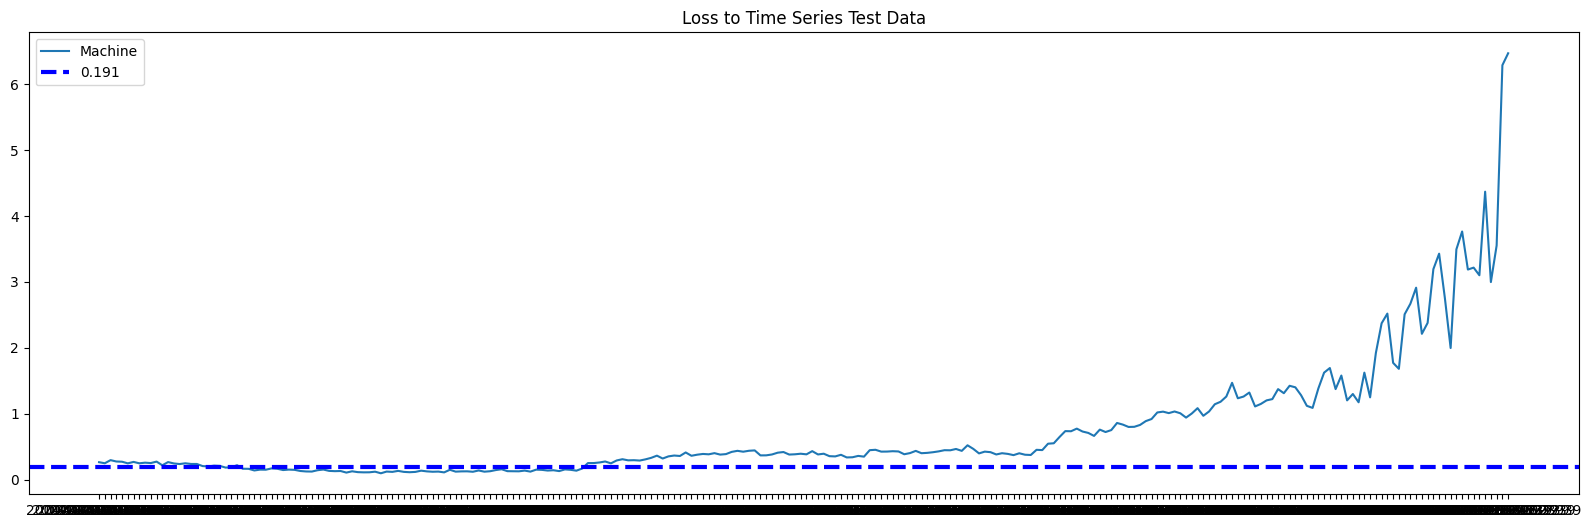

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(test['Loss'], label='Machine')
plt.axhline(threshold, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Loss to Time Series Test Data")
plt.legend()
plt.show()